In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares

In [9]:
# 拟合圆的函数
def fit_circle(x, y):
	"""拟合圆并计算曲率半径"""
	def residuals(params):
		x0, y0, R = params
		return np.sqrt((x - x0)**2 + (y - y0)**2) - R

	# 初始猜测值（圆心在路径中心附近，半径取平均距离）
	x0_guess = np.mean(x)
	y0_guess = np.mean(y)
	R_guess = np.mean(np.sqrt((x - x0_guess)**2 + (y - y0_guess)**2))
	
	# 使用最小二乘法拟合圆
	result = least_squares(residuals, [x0_guess, y0_guess, R_guess])
	 # 拟合圆的圆心坐标和半径
	x0, y0, radius = result.x
	
	# 计算每个点的角度（相对于圆心）
	angles = np.arctan2(y - y0, x - x0)
	
	# 计算角度差（弧长）
	angle_diff = np.diff(angles)  # 计算连续点之间的角度差
	arc_length = np.sum(np.abs(angle_diff)) * radius  # 弧长 = 半径 * 角度差之和
	return radius, arc_length  # 返回曲率半径和弧长

# 计算曲率、运动时间和夹角的函数
def calculate_curvature_and_angles(head_points, tail_points, timestamps):
	# 朝向方向
	head_dirs = head_points - tail_points
	positions = (head_points + tail_points)/2
	
	# 计算每50个连续点的运动曲率半径、时间、夹角
	window_size = 5
	window_interval = 10
	num_windows = (len(head_points)-window_size-1) // window_interval
	curvatures = []
	omegas = []
	angles = []

	for i in range(num_windows):
		start_idx = i * window_interval
		end_idx = i * window_interval + window_size

		# 获取当前窗口的位置数据
		x = positions[start_idx:end_idx, 0]
		y = positions[start_idx:end_idx, 1]
		
		# 拟合曲率半径和弧长
		radius, arc_length = fit_circle(x, y)
		curvatures.append(radius)

		# 计算角速度（omega），即弧长除以半径和时间差
		omega = arc_length / radius / (timestamps[end_idx-1] - timestamps[start_idx])
		omegas.append(omega)

		# 计算夹角：朝向方向和切线方向的夹角
		# 计算路径切向方向：相邻两点之间的方向
		tangent_dirs = positions[start_idx + 1:end_idx + 1] - positions[start_idx:end_idx]  # 相邻点的差值
		tangent_angles = np.arctan2(tangent_dirs[:, 1], tangent_dirs[:, 0])  # 计算切线方向的角度
		
		# 计算朝向方向的角度
		head_angles = np.arctan2(head_dirs[start_idx:end_idx, 1], head_dirs[start_idx:end_idx, 0])  # 头部方向角度
		
		# 计算夹角：朝向方向和路径切线的夹角
		angle_differences = np.abs(tangent_angles - head_angles)  # 计算角度差
		angle_differences = np.minimum(angle_differences, 2 * np.pi - angle_differences)  # 夹角是小于180度的

		# 计算平均夹角
		angles.append(np.mean(angle_differences))

	# 计算窗口内的平均值
	avg_curvatures=np.mean(curvatures)
	avg_omegas=np.mean(omegas)
	avg_angles=np.mean(angles)

	# 计算窗口内的方差
	var_curvatures=np.var(curvatures)
	var_omegas=np.var(omegas)
	var_angles= np.var(angles)
	
	return avg_curvatures, avg_omegas, avg_angles, var_curvatures, var_omegas, var_angles, curvatures, omegas, angles

Average velocity (smoothed): 0.20 units/s


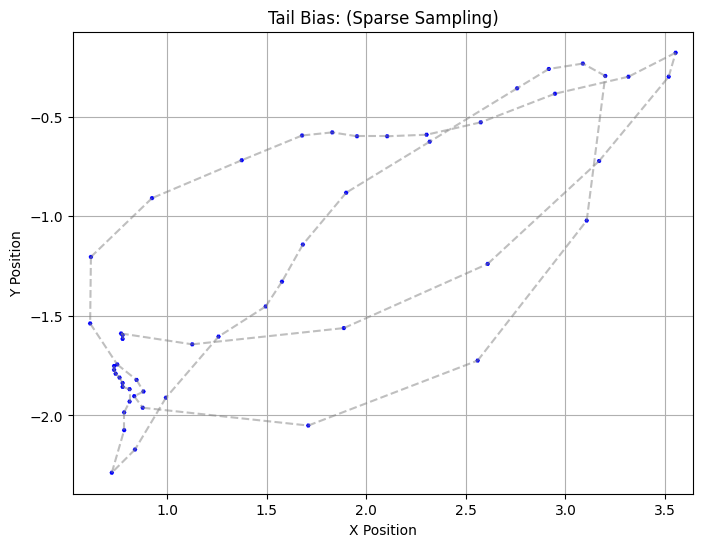

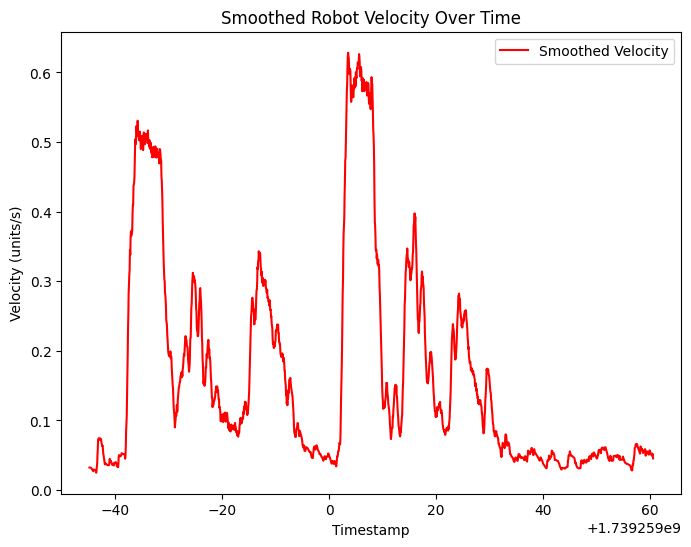

In [6]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置文件夹路径
folder_path = "D:/work/科研项目/snippet/BacksteppingMethod/dynamic_fitting/data"  # 更正了路径格式

# 使用glob获取所有csv文件路径
coeffcient_x = []
coeffcient_y = []

controll_params = []  # [mu_l, mu_r, tail_angle, tail_vel, tail_acc, u, v, omega, u_dot, v_dot]
avg_controll_params = []
csv_file = glob.glob("D:/work/科研项目/snippet/BacksteppingMethod/dynamic_fitting/data/测速.csv")  # 更正了路径格式
df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0', 'state1', 'state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
df = df[((df['head_x'].diff().abs() >= 1) |
         (df['head_y'].diff().abs() >= 1)) &
        ((df['tail_x'].diff().abs() >= 1) |
         (df['tail_y'].diff().abs() >= 1))]
df['head_x'] = df['head_x'] / 515 * 2
df['head_y'] = -df['head_y'] / 515 * 2
df['tail_x'] = df['tail_x'] / 515 * 2
df['tail_y'] = -df['tail_y'] / 515 * 2
df = df.reset_index(drop=True)

# 示例路径点数据（二维点集，包含噪点）
path_points_x = np.array(df['tail_x'])
path_points_y = np.array(df['tail_y'])
tail_points = np.column_stack((path_points_x, path_points_y))
path_points_x = np.array(df['head_x'])
path_points_y = np.array(df['head_y'])
head_points = np.column_stack((path_points_x, path_points_y))
timestamps = np.array(df['timestamp'])
robot_points = (head_points + tail_points) / 2  # 机器人位置是头部和尾部的中点

# 计算机器人速度
distances = np.linalg.norm(np.diff(robot_points, axis=0), axis=1)  # 计算相邻点之间的距离
time_deltas = np.diff(timestamps)  # 计算相邻时间点之间的时间差
velocities = distances / time_deltas  # 速度 = 距离 / 时间

# 进行滑动平均处理
window_size = 10  # 可以调整窗口大小来平滑曲线
smoothed_velocities = np.convolve(velocities, np.ones(window_size) / window_size, mode='valid')

# 平均速度计算
avg_velocity = np.mean(smoothed_velocities)

print(f"Average velocity (smoothed): {avg_velocity:.2f} units/s")

# 绘制机器人的路径和方向（稀疏采样）
fig, ax = plt.subplots(figsize=(8, 6))

# 设置稀疏采样间隔
sample_interval = int(len(timestamps) / 50)  # 每隔50个点画一个箭头

# 遍历采样后的点
for i in range(0, len(head_points), sample_interval):
    head = head_points[i]
    tail = tail_points[i]

    # 计算机器人的朝向向量
    direction = head - tail
    pos = (head + tail) / 2  # 机器人的位置是头部和尾部的中点

    # 画出机器人的位置（箭头的起点）
    ax.quiver(tail[0], tail[1], direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color='blue', headwidth=2)

    # 画出路径
    if i > 0:
        prev_pos = robot_points[i - sample_interval]
        ax.plot([prev_pos[0], pos[0]], [prev_pos[1], pos[1]], color='gray', linestyle='--', alpha=0.5)

# 设置图形参数
ax.set_aspect('equal', 'box')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.title("Tail Bias: (Sparse Sampling)")

# 绘制平滑后的速度曲线
fig_velocity, ax_velocity = plt.subplots(figsize=(8, 6))
ax_velocity.plot(timestamps[window_size:], smoothed_velocities, color='red', label='Smoothed Velocity')  # 绘制平滑后的速度曲线
ax_velocity.set_xlabel('Timestamp')
ax_velocity.set_ylabel('Velocity (units/s)')
ax_velocity.set_title('Smoothed Robot Velocity Over Time')
ax_velocity.legend()

plt.show()


In [135]:
avg_controll_params

[[0,
  1,
  -0.5235987755982988,
  0.08928733043751187,
  0.0649401575780123,
  0.3628735193020456],
 [0,
  1,
  -0.3490658503988659,
  0.08399557834621658,
  0.06658000303977299,
  0.28312378944206473],
 [0,
  1,
  -0.17453292519943295,
  0.12750252765696202,
  0.08619643684622147,
  0.35704621696011624],
 [0, 1, 0.0, 0.12013601448404385, 0.07863055810842626, 0.29079566466209705],
 [0,
  1,
  0.17453292519943295,
  0.09911894331342569,
  0.07052289627017151,
  0.22603332218018649],
 [0,
  1,
  0.3490658503988659,
  0.09771955195709285,
  0.0716225787587799,
  0.21544730302385565],
 [0,
  1,
  0.5235987755982988,
  0.10033988138303844,
  0.0891751342417794,
  0.25051525405699027],
 [0,
  1,
  0.6981317007977318,
  0.06997898659946032,
  0.059417996033350594,
  0.21205046549598253]]

In [148]:
# 根据运动数据生成拟合的系数矩阵
# A_u = F_pecx, Cd_pecx, Cd_b0x, Cd_b1x, Cd_b2x, Cd_b1y, Cd_b2y, Cd_pecy, Cd_b0y

def F_pec_fun(control_params,  coefs):
	k = 1000 * 0.5
	"""动力学模型，模拟位置与速度的关系
	tail_vel: [ [u,v], [u,v] ]
	tail_acc: [ [ax, ay], [ax, ay]]
	"""    
	[mu_l, mu_r, tail_angle,  u, v, omega] = control_params
	[Cd_pecx, Cd_b0x, Cd_b1x, Cd_b2x, Cd_b1y, Cd_b2y] = coefs
	F_pecx = 17.744*v*omega + k * (mu_l+mu_r) * u**2 * Cd_pecx +\
			k * u**2 * Cd_b0x +\
			k * (np.cos(tail_angle)**3*u**2 + 2*np.cos(tail_angle)**2*np.sin(tail_angle)*u*v + np.sin(tail_angle)**2*np.cos(tail_angle)*v**2)* Cd_b1x +\
		   -k * (np.sin(tail_angle)**3*u**2 - 2*np.sin(tail_angle)**2*np.cos(tail_angle)*u*v + np.cos(tail_angle)**2*np.sin(tail_angle)*v**2)* Cd_b1y +\
			k * (np.cos(2*tail_angle)**3*u**2 + 2*np.cos(2*tail_angle)**2*np.sin(2*tail_angle)*u*v + np.sin(2*tail_angle)**2*np.cos(2*tail_angle)*v**2)* Cd_b2x +\
		   -k * (np.sin(2*tail_angle)**3*u**2 - 2*np.sin(2*tail_angle)**2*np.cos(2*tail_angle)*u*v + np.cos(2*tail_angle)**2*np.sin(2*tail_angle)*v**2)* Cd_b2y 
	
	gradient = np.array([
		  k * (mu_l+mu_r) * u**2,
		  k * u**2,
		  k * (np.cos(tail_angle)**3*u**2 + 2*np.cos(tail_angle)**2*np.sin(tail_angle)*u*v + np.sin(tail_angle)**2*np.cos(tail_angle)*v**2),
		  -k * (np.sin(tail_angle)**3*u**2 - 2*np.sin(tail_angle)**2*np.cos(tail_angle)*u*v + np.cos(tail_angle)**2*np.sin(tail_angle)*v**2),
		  k * (np.cos(2*tail_angle)**3*u**2 + 2*np.cos(2*tail_angle)**2*np.sin(2*tail_angle)*u*v + np.sin(2*tail_angle)**2*np.cos(2*tail_angle)*v**2),
		  -k * (np.sin(2*tail_angle)**3*u**2 - 2*np.sin(2*tail_angle)**2*np.cos(2*tail_angle)*u*v + np.cos(2*tail_angle)**2*np.sin(2*tail_angle)*v**2)
	])
	return F_pecx, gradient

# 梯度下降优化
def gradient_descent(control_params_data, F_pec_data, coefs_initial, learning_rate=0.01, max_iters=1000, tol=1e-6):
	coefs = np.array(coefs_initial, dtype=float)  # 转换为浮点数数组
	F_pec_history = []  # 记录每次迭代的F_pec值，用于绘图

	for i in range(max_iters):
		gradients = np.zeros_like(coefs)
		total_loss = 0

		# 计算每个数据点的梯度并累加
		for j in range(len(control_params_data)):
			control_params = control_params_data[j]
			target_F_pec = F_pec_data[j]
			# 计算当前F_pec
			F_pec, grad = F_pec_fun(control_params, coefs)
			gradients += 2*( F_pec-target_F_pec )*grad
			# print(gradients)
			# 计算当前损失
			total_loss += (F_pec - target_F_pec) ** 2
		
		# 平均梯度
		gradients /= len(control_params_data)
		# print(gradients)
		# 更新coefs
		coefs = coefs - learning_rate * gradients

		# 记录F_pec的总损失
		F_pec_history.append(total_loss)
		
		# 检查收敛性
		if total_loss < tol:
			print(f"Converged in {i+1} iterations.")
			break
		print(i,":",total_loss/len(control_params_data), gradients)

	return coefs, F_pec_history


print(len(controll_params))

319


In [13]:
c1 = 0.70 - (0.14) /(1/0.11**2-1/0.16**2)/0.16**2
c1

0.5745185185185184

0 : 1.8273325112253267 [13.71478297 13.71478297 13.08446847  1.07184546 10.65593147  2.84418567]
1 : 1.2993528193036794 [11.34032018 11.34032018 10.77241929  0.87163929  8.89068528  2.3922839 ]
2 : 0.9392204166717018 [9.37919385 9.37919385 8.8637886  0.70576558 7.43367353 2.01786651]
3 : 0.6935734705416958 [7.75943125 7.75943125 7.2883217  0.56825044 6.23121899 1.70745281]
4 : 0.5260158200794967 [6.42159221 6.42159221 5.98799735 0.45416019 5.2389913  1.44990934]
5 : 0.411722954523058 [5.31658682 5.31658682 4.91489762 0.35942018 4.42037936 1.23604117]
6 : 0.33376295304671333 [4.40387312 4.40387312 4.02944854 0.28066523 3.74514719 1.05825435]
7 : 0.28058713574044697 [3.64996871 3.64996871 3.29896725 0.21511608 3.18832384 0.91027716]
8 : 0.24431853068994788 [3.02722142 3.02722142 2.69646199 0.16047737 2.72928658 0.7869298 ]
9 : 0.2195845015101906 [2.51279412 2.51279412 2.19964115 0.1148534  2.35100378 0.68393432]
10 : 0.20272052632487142 [2.08782629 2.08782629 1.79009481 0.07667849 2.0394

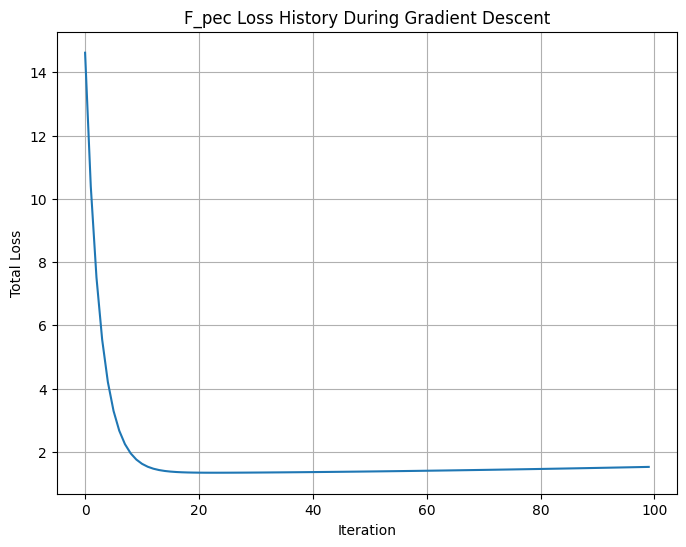

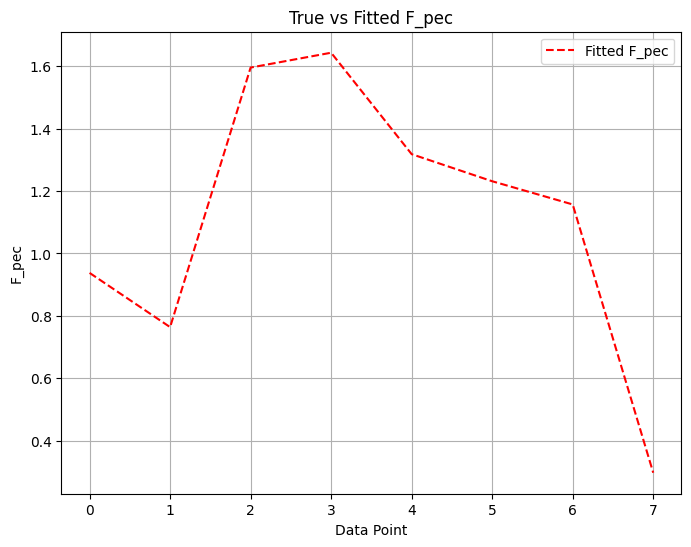

Optimized coefs: [ 0.01627778  0.01627778  0.02700222  0.11190433 -0.02898945  0.0835838 ]


In [149]:
# 初始coefs
coefs_initial = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
F_pec_data = np.ones(len(avg_controll_params))*1.25  # 对应的319个F_pec值
# 使用梯度下降进行优化
optimized_coefs, F_pec_history = gradient_descent(avg_controll_params, F_pec_data, coefs_initial, max_iters=100, learning_rate=0.001)

# 可视化F_pec的收敛过程
plt.figure(figsize=(8, 6))
plt.plot(F_pec_history)
plt.title("F_pec Loss History During Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()

# 使用优化后的coefs计算拟合的F_pec
fitted_F_pec = []
for i in range(len(F_pec_data)):
    f, _ = F_pec_fun(avg_controll_params[i], optimized_coefs)
    fitted_F_pec.append(f)
fitted_F_pec = np.array(fitted_F_pec)               

# 可视化真实F_pec和拟合的F_pec对比
plt.figure(figsize=(8, 6))
# plt.plot(F_pec_data, label='True F_pec', color='b')
plt.plot(fitted_F_pec, label='Fitted F_pec', color='r', linestyle='--')
plt.title("True vs Fitted F_pec")
plt.xlabel("Data Point")
plt.ylabel("F_pec")
plt.legend()
plt.grid(True)
plt.show()

# 打印优化后的系数
print("Optimized coefs:", optimized_coefs)


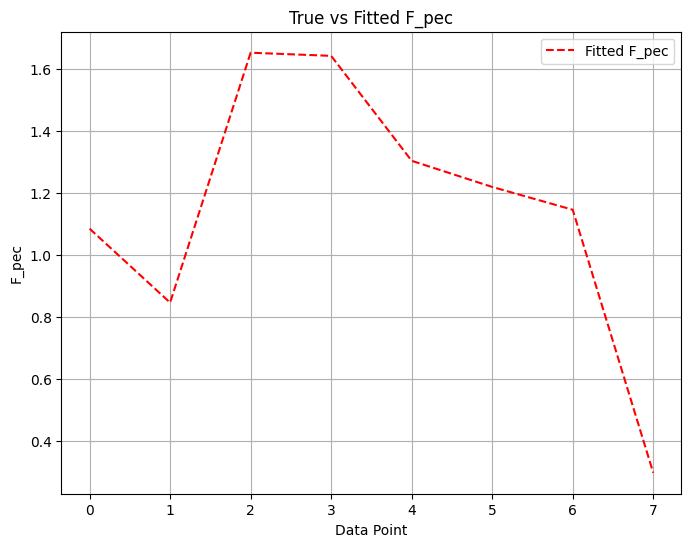

Optimized coefs: [ 0.01627778  0.01627778  0.02700222  0.11190433 -0.02898945  0.0835838 ]


In [150]:
# 使用优化后的coefs计算拟合的F_pec
fitted_F_pec = []
for i in range(len(F_pec_data)):
    f, _ = F_pec_fun(avg_controll_params[i], [ 0.01627778 , 0.01627778 , 0.02700222 , 0.11190433, 0.02898945 , 0.0835838 ])
    fitted_F_pec.append(f)
fitted_F_pec = np.array(fitted_F_pec)               

# 可视化真实F_pec和拟合的F_pec对比
plt.figure(figsize=(8, 6))
# plt.plot(F_pec_data, label='True F_pec', color='b')
plt.plot(fitted_F_pec, label='Fitted F_pec', color='r', linestyle='--')
plt.title("True vs Fitted F_pec")
plt.xlabel("Data Point")
plt.ylabel("F_pec")
plt.legend()
plt.grid(True)
plt.show()

# 打印优化后的系数
print("Optimized coefs:", optimized_coefs)